**Thresh hold methods**


In [16]:
#<libraries>
from skimage import io
from skimage.color import rgb2gray 
from skimage import data,exposure
from skimage.transform import rescale
from skimage.util import random_noise
from skimage import util
from skimage.feature import local_binary_pattern

import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt

from scipy import ndimage
from PIL import Image

import sys,glob
import os
import warnings



%matplotlib inline



**Special Remarks**
 - Grayscale = (R + G + B / 3)

Atempt 1 : Trying to identify the difference layers by using the attempt using different filters    

**Local Binary Pattern for texture classification**

---



1) Read the classes and related  images to each respective names 

In [10]:
# Reading data
image_list = []
pictureDictionary= {}
# settings for LBP
radius = 2
n_points = 8 * radius
METHOD = 'uniform'

os.path.basename('/content/drive/My Drive/canopyPics/labelData')

for filename in glob.glob('/content/drive/My Drive/canopyPics/labelData/*'): #assuming gif
    print(filename)
    image_np=np.array(io.imread(filename, as_gray=True) )
    lbp = local_binary_pattern(image_np, n_points, radius, METHOD)
    fileName_absolute = os.path.basename(filename)
    fileNamesplit = fileName_absolute.split(".")
    pictureDictionary[fileNamesplit[0]] = lbp
    
print("images loaded.")

images loaded.


**Data augmentation to create multiple lbp texture identification** 


why data augmentation is important

---------------------------------------------->



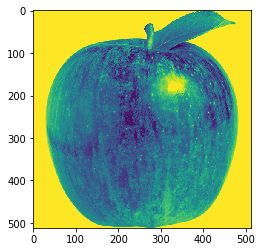

In [15]:
# https://www.kaggle.com/tomahim/image-manipulation-augmentation-with-skimage

#warnings.filterwarnings("ignore")

#original_image = data.chelsea()
original_image   = io.imread('images/testData/apple_test_1.png',as_gray=True)
plt.imshow(original_image)



def image_augmentation(image): 
    #https://www.kaggle.com/safavieh/image-augmentation-using-skimage
    
    """
    This function he the complimentary DNA strand to the given DNA strand as an input. 
    Inorder to compose the complimentary strand, the input string should contain only A,G,T,C 
    bases. The function will halt computation if the DNA strand contain a unknown base.  
    
    Args:
        param1 (String): DNA strand.

    Returns:
        Only known bases (A,G,T,C) : Matching complimentary DNA strand as a string output.
        Unknown base               : 1. error message will be printed with unknown base
                                     2. return None
    """
    
    augmented_images = []  # storting  augmented pictures
    
    # rescale image to 25% of the initial size
    image_rescaled = rescale(original_image, 1.0 / 4.0)
    augmented_images.append(image_rescaled)

    # Noise
    image_with_random_noise = random_noise(original_image)
    augmented_images.append(image_with_random_noise)

    #invert

    #color_inversion_image = util.invert(original_image)
    #augmented_images.append(color_inversion_image)

    # NOte : this can be simply done with numpy

    #color_inversion_image_with_np = np.invert(original_image)
    #augmented_images.append(color_inversion_image_with_np)

    # perform a 45 degree rotation
    image_with_rotation = rotate(original_image, 45)
    #show_images(original_image, image_with_rotation, "Rotated")
    augmented_images.append(image_with_rotation)


    v_min, v_max = np.percentile(original_image, (0.2, 99.8))
    better_contrast = exposure.rescale_intensity(original_image, in_range=(v_min, v_max))
    augmented_images.append(better_contrast)

    # gamma and gain parameters are between 0 and 1
    adjusted_gamma_image = exposure.adjust_gamma(original_image, gamma=0.4, gain=0.9)
    augmented_images.append(adjusted_gamma_image)

    # sigmoid correction 
    sigmoid_correction_image = exposure.adjust_sigmoid(original_image)
    augmented_images.append(sigmoid_correction_image)

    # Vertical flip

    vertical_flip = original_image[::-1, :]
    augmented_images.append(vertical_flip)

    # Blur image 

    blured_image = ndimage.uniform_filter(original_image, size=(11, 11, 1))
    augmented_images.append(blured_image)


In [ ]:
#Kullback–Leibler divergence (also called relative entropy) is a measure of how one probability distribution is different from a second, reference probability distribution
def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

In [17]:

# settings for LBP
radius = 2
n_points = 8 * radius


def matchAll(refs, images):
    imglen = len(images)
    images_np = np.array(images)
    best_score = 10
    best_name = None
    for i in range(0,imglen-1):
      lbp = local_binary_pattern(images_np[i,], n_points, radius, METHOD)
      n_bins = int(lbp.max() + 1)
      hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
      for name, ref in refs.items():
          ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                    range=(0, n_bins))
          score = kullback_leibler_divergence(hist, ref_hist)
          if score < best_score:
              best_score = score
              best_name = name
    return best_name




######################## Reference search #######################################################

#references = creatingRef(augmented_images)
#print(references.shape)
#matchFound(references, ground)

#print("refs",type(pictureDictionary))
#plt.imshow(ground)
#print('original: ground, rotated: 30deg, match result: ',match(pictureDitionaary, rotate(ground, angle=30, resize=False)))
#print("*********************")
######################################################################################################
# classify rotated textures
#print('Rotated images matched against references using LBP:')
#print('original: ground, rotated: 30deg, match result: ',match(refs, rotate(ground, angle=30, resize=False)))
#print('original: ground, rotated: 70deg, match result: ',match(refs, rotate(ground, angle=70, resize=False)))
#print('original: ground_canopy, rotated: 145deg, match result: ',match(refs, rotate(ground_canopy, angle=145, resize=False)))
#print('original: ground, rotated: 70deg, match result: ',match(refs, rotate(ground, angle=70, resize=(5,2))))



In [19]:
# Run the classifier

print('Matched results',matchAll(pictureDictionary,augmented_images))

NameError: name 'augmented_images' is not defined

In [ ]:
# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(9, 6))
plt.gray()

ax1.imshow(ground)
ax1.axis('off')
hist(ax4, refs['ground'])
ax4.set_ylabel('Percentage')

ax2.imshow(ground_canopy)
ax2.axis('off')
hist(ax5, refs['ground_canopy'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(plant)
ax3.axis('off')
hist(ax6, refs['plant'])

ax3.imshow(plant)
ax3.axis('off')
hist(ax6, refs['plant'])


plt.show(rotate(ground, angle=70, resize=(5,2)))

TypeError: ignored

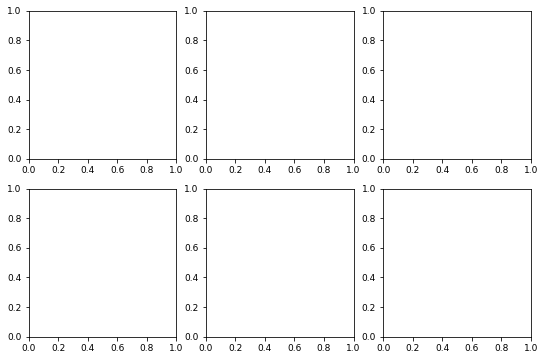

In [56]:
from skimage import data
from skimage.transform import rotate
image = data.camera()


sd   = rotate(image, 2).shape
sd2  = rotate(image, 2, resize=True).shape
sd3  = rotate(image, 90, resize=True).shape

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(9, 6))

ax1.imshow(sd)
ax1.axis('off')
hist(ax4, refs['ground'])
ax4.set_ylabel('Percentage')

ax2.imshow(sd2)
ax2.axis('off')
hist(ax5, refs['ground_canopy'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(sd3)
ax3.axis('off')
hist(ax6, refs['plant'])

ax3.imshow(plant)
ax3.axis('off')
hist(ax6, refs['plant'])
